In [23]:
#from __future__ import absolute_import
#from __future__ import division
#from __future__ import print_function
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 导入数据,并设置加载哪个属性的数据用于训练

In [24]:
df_train = pd.read_csv('../train/Annotations/train.csv', header=None)
df_train.columns = ['image_id', 'class', 'label']
df_train.head()

,image_id,class,label
0,Images/collar_design_labels/4d8a38b29930a403e5...,collar_design_labels,nnynn
1,Images/collar_design_labels/bd0981f231180d2b00...,collar_design_labels,nynnn
2,Images/collar_design_labels/26937e1724feadfe39...,collar_design_labels,ynnnn
3,Images/collar_design_labels/cf4140ec542887270f...,collar_design_labels,nynnn
4,Images/collar_design_labels/50644b2b9de045f2d1...,collar_design_labels,nynnn


In [25]:
#:设置加载哪个属性的数据用于训练
classes = ['collar_design_labels', 'neckline_design_labels', 'skirt_length_labels', 
           'sleeve_length_labels', 'neck_design_labels', 'coat_length_labels', 'lapel_design_labels', 
           'pant_length_labels']

###################################################
#设置加载那个属性的数据用于训练:
cur_class = classes[2]

#设置输入训练模型的图像尺寸,注意:有些使224*224,有些是要求229*229
width = 299
###################################################

In [26]:
#抽取相应属性数据到内存的表格
df_load = df_train[(df_train['class'] == cur_class)].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print("选择的属性为:{0}, 种类的为:{1},样本数: {2}".format(cur_class , len(df_load['label'][0]),len(df_load)))
df_load.head()

选择的属性为:skirt_length_labels, 种类的为:6,样本数: 19333


,image_id,class,label
0,Images/skirt_length_labels/37cc74af47fb302a2d6...,skirt_length_labels,nnynnn
1,Images/skirt_length_labels/8753150147f1266120d...,skirt_length_labels,nnnnny
2,Images/skirt_length_labels/fd868bce2de45a0e4c7...,skirt_length_labels,nnnynn
3,Images/skirt_length_labels/448c9aa2cbafd2475d8...,skirt_length_labels,nnnymn
4,Images/skirt_length_labels/c4f87e3f6fdae6bc0bd...,skirt_length_labels,ynnnnn


In [27]:
df_load[(df_load.index == 2)]

,image_id,class,label
2,Images/skirt_length_labels/fd868bce2de45a0e4c7...,skirt_length_labels,nnnynn


### 加载表格图像并resize到内存

In [28]:
#注意这里的图像resize的设置!!!
n = len(df_load)
n_class = len(df_load['label'][0])
X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n, n_class), dtype=np.uint8)

for i in tqdm(range(n)):
    tmp_label = df_load['label'][i]
    if len(tmp_label) > n_class:
        print(df_load['image_id'][i])
    X[i] = cv2.resize(cv2.imread('../train/{0}'.format(df_load['image_id'][i])), (width, width))
    y[i][tmp_label.find('y')] = 1

100%|██████████| 19333/19333 [03:49<00:00, 84.13it/s]


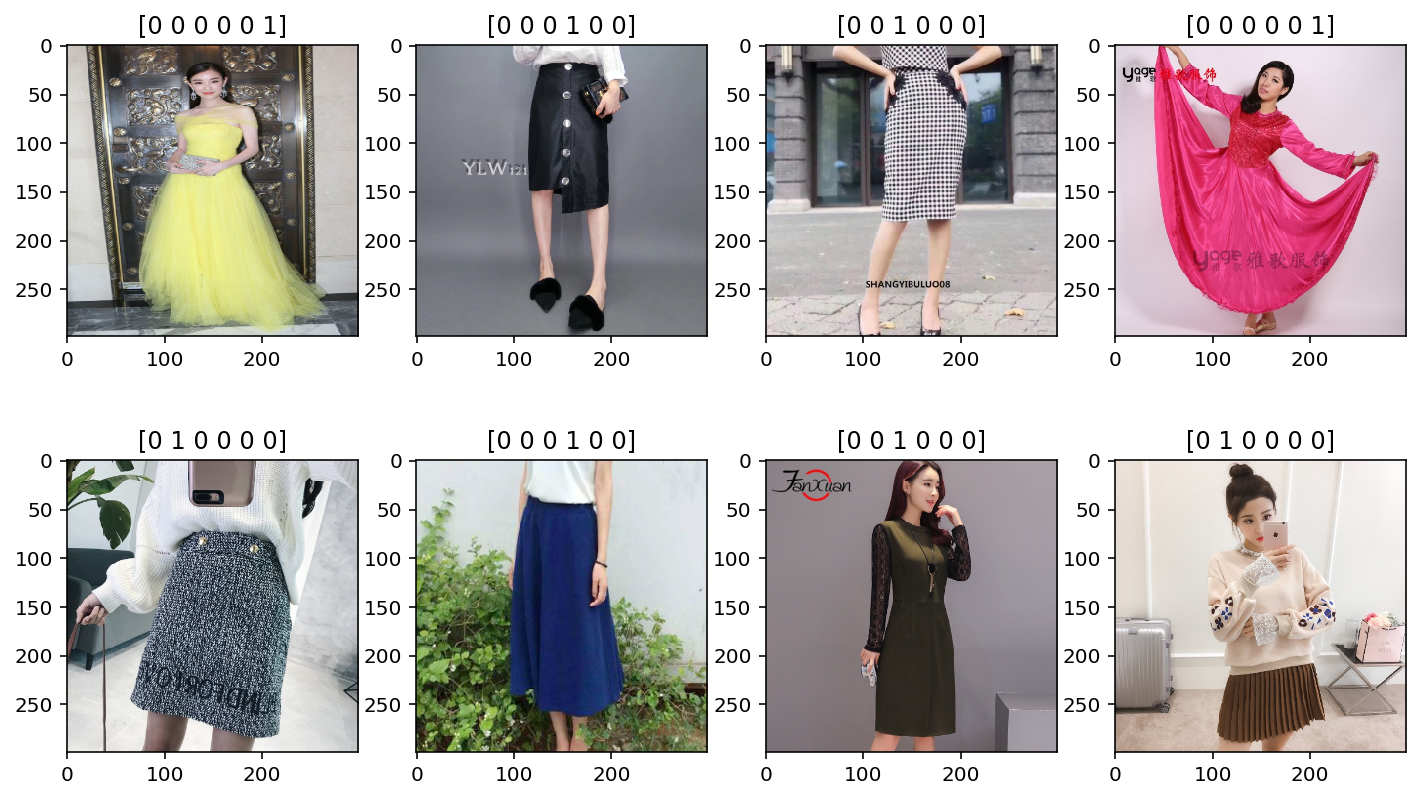

In [29]:
plt.figure(figsize=(12, 7))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X[random_index][:,:,::-1])
    plt.title(y[random_index])

### 提取特征

In [30]:
#########################################################
#注意要from keras.applications import 可以导入所有可用模型,但要注意:
#image size为224*224的预处理函数不同于image size为229*229!!! 如下:

#预处理函数:
from keras.applications.inception_v3 import preprocess_input
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
#导入的image_utils包包含了一系列函数，使得对图片进行前处理以及对分类结果解码更加容易
#VGG16，VGG19以及ResNet接受224×224的输入图像， 而Inception V3和Xception要求为299×299
#使用合适的预处理函数来执行mean subtraction/scaling
#预处理 图像编码服从规定，譬如,RGB，GBR这一类的，preprocess_input(x)  
#preprocessing function is also different (same as Xception)
#return imagenet_utils.preprocess_input(x, mode='tf')
#而其他VGG16，VGG19以及ResNet接受224×224的输入图像,使用preprocess = imagenet_utils.preprocess_input预处理
#InceptionV3和Xception,还有   
#########################################################

from keras.layers import *
#from keras.layers import Input
from keras.models import *
#from keras.models import Model
#from keras.layers import Input, Dense
#a = Input(shape=(32,))
#b = Dense(32)(a)
#model = Model(inputs=a, outputs=b)
from keras.callbacks import *
from keras.optimizers import *
from keras.regularizers import *
# 
from keras.applications import *
#from keras.applications import ResNet50
#from keras.applications import VGG16
#from keras.applications import VGG19
#from keras.applications import Xception # TensorFlow ONLY
#from keras.applications import InceptionResNetV2
#from keras.applications import InceptionV3

#tf.keras.applications.inception_v3.InceptionV3
#tf.keras.applications.inception_resnet_v2.InceptionResNetV2

In [31]:
#import numpy as np
#import argparse
#import cv2


####################################################################
#设置GPU
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
#os.environ["CUDA_VISIBLE_DEVICES"]="0,1" 
os.environ["CUDA_VISIBLE_DEVICES"] = "2"



#看具体的模型参数设置在:https://www.tensorflow.org/api_docs/python/tf/keras/applications
MODELS = {"ResNet50":ResNet50, "InceptionV3":InceptionV3,"DenseNet121":DenseNet121,
        "DenseNet169":DenseNet169,"DenseNet201":DenseNet201,"Xception":Xception, 
        "InceptionResNetV2":InceptionResNetV2,"NASNetLarge":NASNetLarge}
#设置项
Network = MODELS["InceptionV3"]
#设置model,不同model放在不同文件夹下
mymodel = "InceptionV3"

#设置预处理方式,当为224*224时选择如下:
#ppreprocess = imagenet_utils.preprocess_input 
#为229*229,设置如下
ppreprocess = preprocess_input
##############################################################

In [32]:
#input_tensor: optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model.
#pooling: Optional pooling mode for feature extraction when include_top is False. - None means that the output of the model will be the 4D tensor output of the last convolutional layer. - 'avg' means that global average pooling will be applied to the output of the last convolutional layer, and thus the output of the model will be a 2D tensor. - 'max' means that global max pooling will be applied.
#cnn_model = Xception(include_top=False,input_shape=(width, width, 3), weights='imagenet',)
#当include_top=False,即在最后卷积末尾新加pooling='avg'的全局均值采用,得到全局滤波器个数*1的二维输出
cnn_model = Network(include_top=False, input_shape=(width, width, 3), weights='imagenet',pooling='avg')

inputs = Input((width, width, 3))
x = inputs
x = Lambda(ppreprocess, name='preprocessing')(x)
x = cnn_model(x)
#下面是新加的层
#x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
# n_class为对应属性的分类个数
x = Dense(n_class, activation='softmax', name='softmax')(x)

model = Model(inputs, x)

### 划分训练、测试集

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.12, random_state=42)
X_train.shape, y_train.shape

((17013, 299, 299, 3), (17013, 6))

In [34]:
adam = Adam(lr=0.001)
prefix_cls = cur_class.split('_')[0]

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='../models/{0}/{0}_{1}.best.h5'.format(prefix_cls,mymodel), verbose=1, 
                               save_best_only=True)

h = model.fit(X_train, y_train, batch_size=32, epochs=80, 
              callbacks=[EarlyStopping(patience=3), checkpointer], 
              shuffle=True, 
              validation_split=0.1)

Train on 15311 samples, validate on 1702 samples
Epoch 1/80
15311/15311 [==============================] - 178s 12ms/step - loss: 0.8363 - acc: 0.6932 - val_loss: 0.7401 - val_acc: 0.7673

Epoch 00001: val_loss improved from inf to 0.74008, saving model to ../models/skirt/skirt_InceptionV3.best.h5
Epoch 2/80
15311/15311 [==============================] - 168s 11ms/step - loss: 0.5299 - acc: 0.8116 - val_loss: 0.7441 - val_acc: 0.7444

Epoch 00002: val_loss did not improve
Epoch 3/80
15311/15311 [==============================] - 170s 11ms/step - loss: 0.4074 - acc: 0.8572 - val_loss: 0.6630 - val_acc: 0.7991

Epoch 00003: val_loss improved from 0.74008 to 0.66302, saving model to ../models/skirt/skirt_InceptionV3.best.h5
Epoch 4/80
15311/15311 [==============================] - 168s 11ms/step - loss: 0.3164 - acc: 0.8905 - val_loss: 0.6163 - val_acc: 0.7973

Epoch 00004: val_loss improved from 0.66302 to 0.61628, saving model to ../models/skirt/skirt_InceptionV3.best.h5
Epoch 5/80
1531

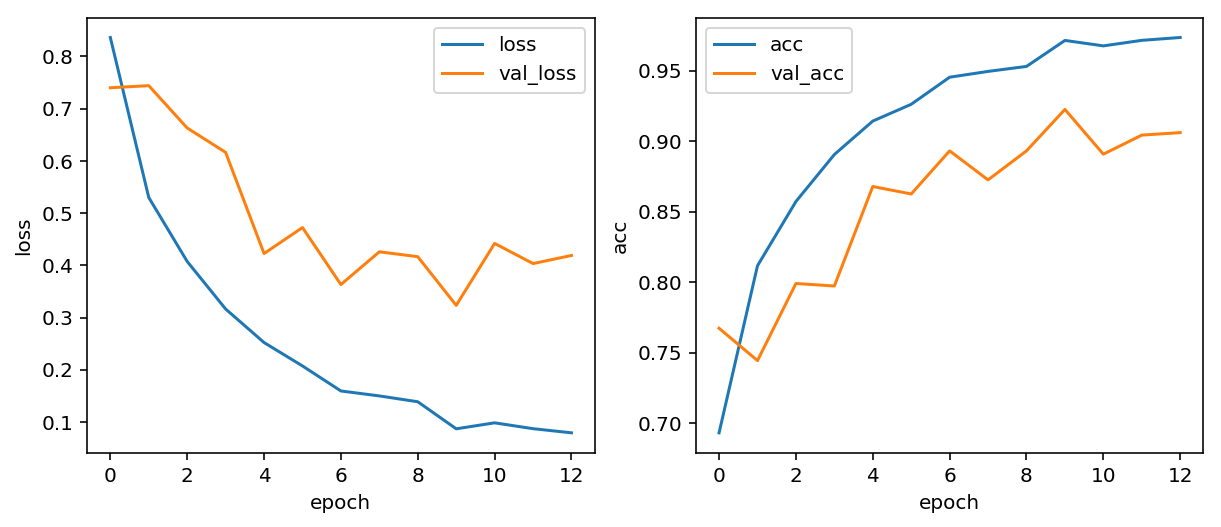

In [35]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
#保存
plt.savefig('../models/{0}/{0}_{1}.png'.format(prefix_cls, mymodel),bbox_inches='tight')

In [36]:
model.evaluate(X_train, y_train, batch_size=256)

17013/17013 [==============================] - 72s 4ms/step


[0.21430447330650307, 0.93634279674444709]

In [37]:
model.evaluate(X_valid, y_valid, batch_size=256)

2320/2320 [==============================] - 10s 4ms/step


[0.48692114057725872, 0.88405172413793098]

### 加载测试集

In [38]:
df_test = pd.read_csv('../test/Tests/question.csv', header=None)
df_test.columns = ['image_id', 'class', 'x']
del df_test['x']
df_test.head()

,image_id,class
0,Images/collar_design_labels/60951f5761ea3a01d6...,collar_design_labels
1,Images/collar_design_labels/677e1183282769a3fe...,collar_design_labels
2,Images/collar_design_labels/3f5a2be205e5d253eb...,collar_design_labels
3,Images/collar_design_labels/1712bf3d7b57d779ad...,collar_design_labels
4,Images/collar_design_labels/0b2b4254f35ce3a41a...,collar_design_labels


In [39]:
df_load = df_test[(df_test['class'] == cur_class)].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print('{0}: {1}'.format(cur_class, len(df_load)))
df_load.head()

skirt_length_labels: 1153


,image_id,class
0,Images/skirt_length_labels/704c6687f416cf0ec75...,skirt_length_labels
1,Images/skirt_length_labels/77b794c13dd8fcfd606...,skirt_length_labels
2,Images/skirt_length_labels/5c556f442d9910477d6...,skirt_length_labels
3,Images/skirt_length_labels/7ae040079fa127bc91d...,skirt_length_labels
4,Images/skirt_length_labels/c72f084d5b53dc8c25b...,skirt_length_labels


In [40]:
n = len(df_load)
X_test = np.zeros((n, width, width, 3), dtype=np.uint8)

for i in tqdm(range(n)):
    X_test[i] = cv2.resize(cv2.imread('../test/{0}'.format(df_load['image_id'][i])), (width, width))

100%|██████████| 1153/1153 [00:12<00:00, 93.96it/s]


In [41]:
test_np = model.predict(X_test, batch_size=256)

In [42]:
test_np.shape

(1153, 6)

In [43]:
result = []

for i, row in df_load.iterrows():
    tmp_list = test_np[i]
    tmp_result = ''
    for tmp_ret in tmp_list:
        tmp_result += '{:.4f};'.format(tmp_ret)
        
    result.append(tmp_result[:-1])

df_load['result'] = result
df_load.head()

,image_id,class,result
0,Images/skirt_length_labels/704c6687f416cf0ec75...,skirt_length_labels,0.0009;0.0000;0.0001;0.9116;0.0873;0.0000
1,Images/skirt_length_labels/77b794c13dd8fcfd606...,skirt_length_labels,0.0000;0.0000;0.0000;0.0000;0.0000;1.0000
2,Images/skirt_length_labels/5c556f442d9910477d6...,skirt_length_labels,0.0002;0.0000;0.0000;0.0003;0.0001;0.9993
3,Images/skirt_length_labels/7ae040079fa127bc91d...,skirt_length_labels,0.0001;0.9999;0.0000;0.0000;0.0000;0.0000
4,Images/skirt_length_labels/c72f084d5b53dc8c25b...,skirt_length_labels,0.0000;0.0000;0.0000;0.0000;0.0179;0.9821


In [44]:
df_load.to_csv('../result/{1}/{0}_{1}.csv'.format(prefix_cls, mymodel), header=None, index=False)
prefix_cls

'skirt'